**[CAT 2 Assessment]()**

Note: This notebook has all the libraries need already imported. You are thus limited to using:

*   Tensforlow for builing your ANN
*   Pandas for reading data (already done for you)
*   Sklearn for Data spliting
*   Matplotlib for plots


You need to upload the provided csv nmed 'CAT2_data.csv' file to this runtime. This file can be downloaded from:

[E_learning](https://elearning.strathmore.edu/mod/resource/view.php?id=223539) OR
[Google Drive](https://drive.google.com/file/d/1xJwoSy9KTC1ETodnKNFetgNOWuJqxR6s/view?usp=sharing)

For those working offline, ensure you know the file path to the downloaded csv file. The easiest way to do this would be to have both the Notebook and CSV files in the same folder. You can also run ```python % ls ``` on an empty cell to confirm.

Additionals:

*   Train for at least 30 epochs, 50 recommended
*   This does not need a GPU. *Training 30 epochs on a Dual Core 2.4 Ghz CPU takes about 2 minutes (could be less)*

-------

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense

2023-07-05 13:21:19.805150: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 13:21:19.806906: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 13:21:19.848340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 13:21:19.848908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 13:21:20.743680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Data Aquisition

In [8]:
df = pd.read_csv('data.csv')                                               # read data

df['X'].iloc[np.random.choice(df.index, 50, replace=False)] = np.nan            # randomly drop 50 rows
df = df.sample(frac=1).reset_index(drop=True)                                   # shuffle rows

labels = df['Y'].unique()                                                       # get unique labels

df = df[df['Y'].isin(np.random.choice(labels, 2, replace=False))]               # randomly choose 2 labels
df = df.reset_index(drop=True)                                                  # reset index

print('Your will be using the two labels below with value counts as shown. Runing this cell again will generate another randomised dataframe for you to use')
print(df['Y'].value_counts())                                                   # check value counts
print(df.shape)                                                                 # check shape, rows and columns

df.head()

Your will be using the two labels below with value counts as shown. Runing this cell again will generate another randomised dataframe for you to use
 Cardiovascular / Pulmonary    372
 Orthopedic                    355
Name: Y, dtype: int64
(727, 2)


,X,Y
0,Closed reduction and placement of long-arm cast.,Orthopedic
1,Decreased ability to perform daily living act...,Orthopedic
2,Carotid Ultrasonic & Color Flow Imaging,Cardiovascular / Pulmonary
3,"Left Cardiac Catheterization, Left Ventriculo...",Cardiovascular / Pulmonary
4,Left little finger extensor tendon laceration...,Orthopedic


### Data Preparation / Preprocessing

In [26]:
# Data encoding using length of the string because comparison was not working for some reason

df["target"] = df["Y"].apply(lambda x: 1 if len(x) == 11 else 0)
df.head()


,X,Y,targets,target
0,Closed reduction and placement of long-arm cast.,Orthopedic,0,1
1,Decreased ability to perform daily living act...,Orthopedic,0,1
2,Carotid Ultrasonic & Color Flow Imaging,Cardiovascular / Pulmonary,0,0
3,"Left Cardiac Catheterization, Left Ventriculo...",Cardiovascular / Pulmonary,0,0
4,Left little finger extensor tendon laceration...,Orthopedic,0,1


In [31]:
# Data cleaning

df['X'] = df['X'].str.replace('@','')
df['X'] = df['X'].str.replace('#','')
df['X'] = df['X'].str.replace('\d+','')
df['X'] = df['X'].str.replace('\s+',' ')

df['X'] = df['X'].str.lower()
df = df.dropna()
df.head()
df.drop('targets', axis=1)

,X,Y,target
0,closed reduction and placement of long-arm cast.,Orthopedic,1
1,decreased ability to perform daily living act...,Orthopedic,1
2,carotid ultrasonic & color flow imaging,Cardiovascular / Pulmonary,0
3,"left cardiac catheterization, left ventriculo...",Cardiovascular / Pulmonary,0
4,left little finger extensor tendon laceration...,Orthopedic,1
...,...,...,...
721,the patient had undergone mitral valve repair...,Cardiovascular / Pulmonary,0
723,noncontrast ct scan of the lumbar spine. left...,Orthopedic,1
724,"left heart catheterization, bilateral selecti...",Cardiovascular / Pulmonary,0
725,a -year-old white male started to complain of...,Orthopedic,1


### Modeling

In [32]:
# Train Test Splits
train_texts, test_texts, train_labels, test_labels = train_test_split(df['X'],df['target'],test_size=0.2)

In [36]:
tokeniser = Tokenizer()
tokeniser.fit_on_texts(train_texts)

train_seq = tokeniser.texts_to_sequences(train_texts)
test_seq  = tokeniser.texts_to_sequences(test_texts)

In [37]:
max_len = max(max(map(len, train_seq)), max(map(len,train_seq)))
max_len

75

In [38]:
train_data = pad_sequences(train_seq,max_len)
test_data = pad_sequences(test_seq,max_len)

In [39]:
model = Sequential()
model.add(Embedding(len(tokeniser.word_index) + 1, 300, input_length = max_len))
model.add(LSTM(128))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2023-07-05 13:50:16.095328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 13:50:16.097122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 13:50:16.099572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [40]:
history = model.fit(train_data, train_labels, validation_data = (test_data,test_labels), epochs = 30, batch_size = 64)

Epoch 1/30


2023-07-05 13:50:48.724572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 13:50:48.726626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 13:50:48.727937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.6360

2023-07-05 13:50:52.549089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 13:50:52.552605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 13:50:52.555397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 5s 248ms/step - loss: 0.6790 - accuracy: 0.6360 - val_loss: 0.6608 - val_accuracy: 0.5899
Epoch 2/30
9/9 [==============================] - 1s 154ms/step - loss: 0.5163 - accuracy: 0.8396 - val_loss: 0.3495 - val_accuracy: 0.8273
Epoch 3/30
9/9 [==============================] - 1s 158ms/step - loss: 0.2677 - accuracy: 0.9117 - val_loss: 0.2859 - val_accuracy: 0.9568
Epoch 4/30
9/9 [==============================] - 1s 153ms/step - loss: 0.1888 - accuracy: 0.9892 - val_loss: 0.2095 - val_accuracy: 0.9568
Epoch 5/30
9/9 [==============================] - 1s 130ms/step - loss: 0.0932 - accuracy: 0.9928 - val_loss: 0.1177 - val_accuracy: 0.9640
Epoch 6/30
9/9 [==============================] - 1s 132ms/step - loss: 0.0410 - accuracy: 0.9946 - val_loss: 0.0682 - val_accuracy: 0.9856
Epoch 7/30
9/9 [==============================] - 1s 159ms/step - loss: 0.0202 - accuracy: 0.9982 - val_loss: 0.0541 - val_accuracy: 0.9928
Epoch 8/30
9/9 [===============

### Evaluation

In [41]:
# plot loss and accuracy
def plot(metric):
    plt.plot(history.history[metric])
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [42]:
loss, acc = model.evaluate(test_data, test_labels)

print(loss)
print(acc)

5/5 [==============================] - 0s 15ms/step - loss: 0.1393 - accuracy: 0.9496
0.13930872082710266
0.9496402740478516


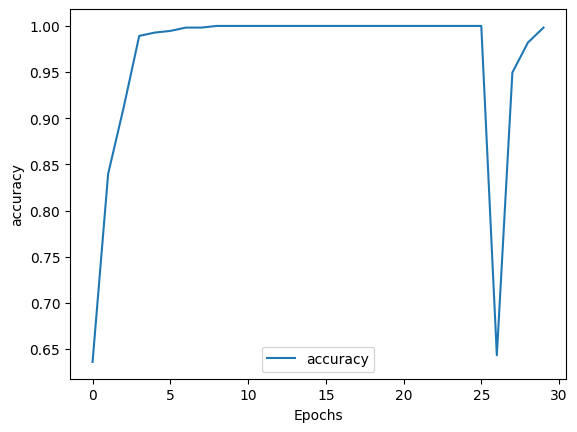

In [44]:
plot("accuracy")

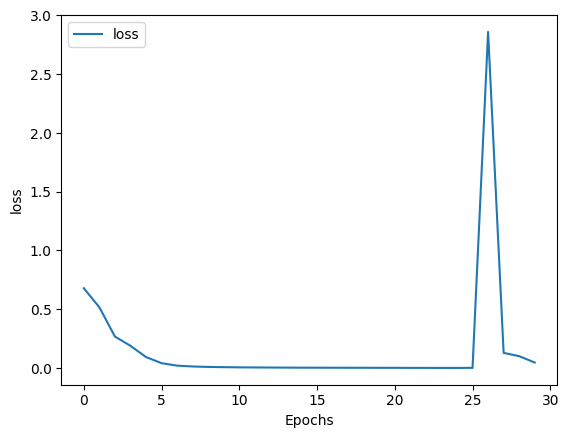

In [45]:
plot("loss")

### Save Files

In [46]:
import numpy as np 

def clf(model, token, text):
    seq = token.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen = model.input_shape[1])

    pred = model.predict(seq)
    pred_label = np.round(pred[0].astype(int))

    if pred_label ==0:
        return 'Cardiovascular / Pulmonary'
    else:
        return 'Orthopedic'

In [47]:
# exporting the model 

model.save('C-135357.h5')

from tensorflow.keras.models import load_model